# Модель кредитного скоринга

**Цель проекта:** определить, как влияют семейное положение клиента и наличие у него детей на закрытие кредита в срок 

### Содержание

1. [Изучение данных](#1id)

2. [Предобработка данных](#2id)
    * [Поиск пропущенных значений](#2.1id)
    * [Заполнение пропущенных и замена некорректных значений](#2.2id)
    * [Изменение типов данных](#2.3id)
    * [Поиск и обработка дубликатов](#2.4id)
3. [Лемматизация](#3id)
4. [Категоризация данных](#4id)
    * [Создание категорий](#4.1id)
    * [Категоризация по наличию детей](#4.2id)
    * [Категоризация по уровню дохода](#4.3id)
5. [Поиск влияния факторов на погашения кредита в срок](#5id)
    * [Зависимость между наличием детей и возвратом кредита в срок](#5.1id)
    * [Зависимость между семейным положением и возвратом кредита в срок](#5.2id)
    * [Зависимость между уровнем дохода и возвратом кредита в срок](#5.3id)
    * [Влияние целей кредита на его возврат в срок](#5.4id)
6. [Итоги исследования и реккомендации](#6id)

## Шаг 1. Изучение данных <a id="1id"></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib as plt

Импортируем нужные библиотеки и изучим данные 

In [2]:
try:
    data = pd.read_csv('/home/olga/Downloads/data.csv') 
except:    
    data = pd.read_csv('/datasets/data.csv')

from pymystem3 import Mystem
m = Mystem() 

import seaborn

display(data.head(10))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [3]:
# взглянем на общую информацию датафрейма

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


В датасете 12 столбцов. В столбцах "days_employed" и "total_income" есть пропуски. 
Применим также метод describe(), чтобы взглянуть на основные статистические данные, возможные аномалии.

In [4]:
data.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


В столбце "children" находим пару неоднозначных значений. Минимальным зачением является отрицательное число. Подозрительным числом кажется и максимальное значение - 20, что является большой редкостью. Однако оставим этот выброс, так как перед нами стоит вопрос оценить возврат кредита в срок у людей имеющих детей и бездетных. Средний показатель количества детей нам не понадобится.
Также видим большое количество отрицательных значений и далекие от действительности данные по стажу: более 75% значений отрицательны и максимальный стаж в 1100 лет - странность.

## Шаг 2. Предобработка данных <a id="2id"></a>

### 2.1 Поиск пропущенных значений <a id="2.1id"></a>

In [5]:
# поиск пропущенных значений

print(data.isna().sum())

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64


In [6]:
# выведем датасет, где в обоих столбцах встречаются пропущенные значения

na_strings = data[data['days_employed'].isna() & data['total_income'].isna()]
display(na_strings.head())

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу


In [7]:
len(na_strings['days_employed'])

2174

In [8]:
len(na_strings['total_income'])

2174

В датасете мы обнаружили по 2174 пропуска в столбцах, где указан общий трудовой страж(days_employed), а также ежемесячный доход(total_income). Количество пропущенных значений в обоих столбцах одинаковое. Причиной пропусков может быть ошибка в выгрузке данных, объединение нескольких таблиц и просто отсутствие иниформации.

Вывели строки, где в обоих стобцах встречаются пустые значения. Есть закономерность: если значения отсутствуют в стобце 'days_employed', то в тех же строках они отсутсвуют и в столбце 'total_income'

### 2.2 Заполнение пропущенных и замена некорректных значений <a id="2.2id"></a>

Здесь мы столкнулись с пропусками в столбцах с количественными переменными. При удалении 2174 сторк мы потеряем большой объем информации, поэтому для заполнения пропусков выберем медианные значения

In [9]:
avr_days_employed = data['days_employed'].median()  # среднее значение по столбцу "days_employed"
print('Cреднее значение трудового стажа:', round(avr_days_employed))

avr_total_income = data['total_income'].median()  # среднее значение по столбцу "total_income"
print('Среднее значение ежемесячного дохода:', round(avr_total_income))

Cреднее значение трудового стажа: -1203
Среднее значение ежемесячного дохода: 145018


In [10]:
# Заменим пропущенные значения в столбцах значениями медианы

data['days_employed'] = data['days_employed'].fillna(avr_days_employed)
data['total_income'] = data['total_income'].fillna(avr_total_income)

print(data.isna().sum())  # проверим, что пустых значений не осталось

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64


Сделаем все значение в столбце "children" положительными и проверим, что отрицательных не осталось

In [11]:
data['children'] = abs(data['children'])
print((data['children'] < 0).value_counts())

False    21525
Name: children, dtype: int64


В представленном датасете мы обнаружили и заполнили пропуски в столбцах 'days_employed' и 'total_income' медианным значением. Убедились, что после совершенных действий пустых значений не осталось.

### 2.3 Изменение типов данных <a id="2.3id"></a>

Изменим тип данных о стаже с вещественных на целочисленные значения в столбце "days_employed"

In [12]:
# используем метод astype() для перевода значений в нужный тип

data['days_employed'] = data['days_employed'].astype('int')
print(data['days_employed'])

0         -8437
1         -4024
2         -5623
3         -4124
4        340266
          ...  
21520     -4529
21521    343937
21522     -2113
21523     -3112
21524     -1984
Name: days_employed, Length: 21525, dtype: int64


Видим, что значения в столбце "days_employed" отрицательные, что не характерно для стажа работы. 
Возможно, некоторые значения заполнялись в ручную, используя тире. Преобразуем числа в абсолютные значения с помощью функции для нахождения модуля abs() и проверим новые значения.

In [13]:
data['days_employed'] = abs(data['days_employed'])
print(data['days_employed'])

0          8437
1          4024
2          5623
3          4124
4        340266
          ...  
21520      4529
21521    343937
21522      2113
21523      3112
21524      1984
Name: days_employed, Length: 21525, dtype: int64


Теперь показатели стажа работы положительные целочисленные значения.

Выведем значения стажа у пенсионеров. Цифры слишком большие, чтобы быть действительностью. Возможно, данные записаны в другом формате исчисления (не в днях), или вещественные значения были записаны некорректно: плавающая точка оказалась не в том месте. Как вариант, можно разделить все значения, превышающие четыре знака, на 100. Но в данном случае изменение данных никак не повлияет на наши дальнейшие исследования

In [14]:
print(data[data['income_type'] == 'пенсионер']['days_employed'])

4        340266
12         1203
18       400281
24       338551
25       363548
          ...  
21505    338904
21508    386497
21509    362161
21518    373995
21521    343937
Name: days_employed, Length: 3856, dtype: int64


In [15]:
print(data[data['income_type'] == 'сотрудник']['days_employed'])

0        8437
1        4024
2        5623
3        4124
7         152
         ... 
21515     467
21519    2351
21522    2113
21523    3112
21524    1984
Name: days_employed, Length: 11119, dtype: int64


### 2.4 Поиск и обработка дубликатов <a id="2.4id"></a>

Проверим, есть ли в таблице дубликаты, которые не позволят корректно проанализировать данные

In [16]:
data.duplicated().sum()  # поиск явных дубликатов

54

В датафрейме мы обнаружили 54 дубликата, которые мы удалим методом drop_duplicates()

In [17]:
data.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

In [18]:
data = data.drop_duplicates().reset_index(drop=True)

In [19]:
data.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

In [20]:
data.duplicated().sum() # повторно проверим наличие дубликатов

0

Теперь попробуем найти неявные дубликаты, которые могут быть спрятаны за некорректным типом данных, разным регистром и тд.

In [21]:
data['days_employed'].value_counts()

1203      2125
327         16
133         16
438         15
204         14
          ... 
8200         1
9090         1
360849       1
2101         1
343937       1
Name: days_employed, Length: 9086, dtype: int64

In [22]:
data['education'].value_counts()

среднее                13705
высшее                  4710
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   273
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

Видим, что в значениях столбца много дубликатов. Приведем все строки к одному регистру

In [23]:
data['education'] = data['education'].str.lower()
print(data['education'].value_counts())

среднее                15188
высшее                  5251
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64


Теперь у нас всего пять значений в столбе "образование". Проверим на неявные дубликаты столбец 'education' методом unique():

In [24]:
data['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

In [25]:
print(data['family_status'].value_counts())

женат / замужем          12344
гражданский брак          4163
Не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64


В столбце 'family_status' у нас все в порядке. Но для визуального удобства тоже приведем все значения к нижнему регистру

In [26]:
data['family_status'] = data['family_status'].str.lower()
print(data['family_status'].value_counts())

женат / замужем          12344
гражданский брак          4163
не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64


In [27]:
print(data['gender'].value_counts())

F      14189
M       7281
XNA        1
Name: gender, dtype: int64


В столбце о доходах оставим два знака после запятой

In [28]:
data['total_income'].round(2)

0        253875.64
1        112080.01
2        145885.95
3        267628.55
4        158616.08
           ...    
21466    224791.86
21467    155999.81
21468     89672.56
21469    244093.05
21470     82047.42
Name: total_income, Length: 21471, dtype: float64

In [29]:
print(data['income_type'].value_counts())

сотрудник          11091
компаньон           5080
пенсионер           3837
госслужащий         1457
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64


In [30]:
print(data['purpose'].value_counts())

свадьба                                   793
на проведение свадьбы                     773
сыграть свадьбу                           769
операции с недвижимостью                  675
покупка коммерческой недвижимости         662
покупка жилья для сдачи                   652
операции с жильем                         652
операции с коммерческой недвижимостью     650
покупка жилья                             646
жилье                                     646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          625
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

В столбце "purpose" много похожих значений, которые можно распределить в общие категории.

**Вывод:** мы избавились от дубликатов в датасете.Причины их возникновения могут быть различны: ручное заполенение датасета, некорректная выгрузка данных, объединение нескольких таблиц. Также скорректировали тип данных в необходимом столбце, заменили значения на корректные.

## Шаг 3. Лемматизация <a id="3id"></a>

Чтобы определить причины взятия кредита, рассмотрим столбец "purpose" и проведем процесс лемматизации, который позволит разбить данные в ячейках на категории

In [31]:
purpose = data['purpose'].value_counts()
purpose

свадьба                                   793
на проведение свадьбы                     773
сыграть свадьбу                           769
операции с недвижимостью                  675
покупка коммерческой недвижимости         662
покупка жилья для сдачи                   652
операции с жильем                         652
операции с коммерческой недвижимостью     650
покупка жилья                             646
жилье                                     646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          625
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

Разобьем данные столбца на четыре логические категории:
1. свадьба
2. недвижимость
3. автомобиль
4. образование

Лемматизация возможна только для строк. Создадим пустую строку и циклом заполним ее значениями из столбца "purpose"

In [32]:
purpose = data['purpose'].unique()  # заносим в переменную уникальные значения столбца purpose
purpose_row = ''


for row in purpose:
    purpose_row += row + ' '
    
print(purpose_row)

покупка жилья приобретение автомобиля дополнительное образование сыграть свадьбу операции с жильем образование на проведение свадьбы покупка жилья для семьи покупка недвижимости покупка коммерческой недвижимости покупка жилой недвижимости строительство собственной недвижимости недвижимость строительство недвижимости на покупку подержанного автомобиля на покупку своего автомобиля операции с коммерческой недвижимостью строительство жилой недвижимости жилье операции со своей недвижимостью автомобили заняться образованием сделка с подержанным автомобилем получение образования автомобиль свадьба получение дополнительного образования покупка своего жилья операции с недвижимостью получение высшего образования свой автомобиль сделка с автомобилем профильное образование высшее образование покупка жилья для сдачи на покупку автомобиля ремонт жилью заняться высшим образованием 


In [33]:
lemmas = m.lemmatize(purpose_row)

from collections import Counter
print(Counter(lemmas))

Counter({' ': 96, 'покупка': 10, 'недвижимость': 10, 'автомобиль': 9, 'образование': 9, 'жилье': 7, 'с': 5, 'операция': 4, 'на': 4, 'свой': 4, 'свадьба': 3, 'строительство': 3, 'получение': 3, 'высокий': 3, 'дополнительный': 2, 'для': 2, 'коммерческий': 2, 'жилой': 2, 'подержать': 2, 'заниматься': 2, 'сделка': 2, 'приобретение': 1, 'сыграть': 1, 'проведение': 1, 'семья': 1, 'собственный': 1, 'со': 1, 'профильный': 1, 'сдача': 1, 'ремонт': 1, ' \n': 1})


Произведена лемматизация значений столбца. На ее основе можем категоризировать данные

## Шаг 4. Категоризация данных <a id="4id"></a>

### 4.1 Создание категорий <a id="4.1id"></a>

Создадим четыре списка с выявленными раннее категориями и внесем туда леммы (значения), которые соответствуют конкретной категории

In [34]:
wedding = ['свадьба', 'сыграть']
real_estate = ['жилье','недвижимость', 'строительство', 'жилой', 'сдача', 'ремонт']
car = ['автомобиль', 'подержать']
education = ['образование', 'профильный']

In [35]:
# создадим функцию, которая определяет категорию по лемме

def purpose_category(purpose):
    lemmas = m.lemmatize(purpose)
    for lemma in lemmas:
        if lemma in wedding:
            return 'свадьба'
        if lemma in real_estate:
            return 'недвижимость'
        if lemma in car:
            return 'автомобиль'
        if lemma in education:
            return 'образование'   

In [36]:
# создадим новый столбец, куда внесем категорию цели взятия кредита клиента

data['purpose_category'] = data['purpose'].apply(purpose_category)

In [37]:
# посчитаем количество каждой категории

data['purpose_category'].value_counts()

недвижимость    10814
автомобиль       4308
образование      4014
свадьба          2335
Name: purpose_category, dtype: int64

Чаще всего клиенты берут кредит для преобретения недвижимости

### 4.2 Категоризация по наличию детей <a id="4.2id"></a>

Проведем категоризацию по количеству детей в семье.
Выделим "бездетная", "малодетная" и "многодетная"

In [38]:
# создаем функцию, которая категоризирует семьи по количеству детей

def children_category(children):
    
    if children == 0:
        return 'бездетная'
    if 1 <= children <= 2:
        return 'малодетная'
    return 'многодетная'

In [39]:
data['children_category'] = data['children'].apply(children_category)

In [40]:
print(data['children_category'].value_counts())

бездетная      14107
малодетная      6908
многодетная      456
Name: children_category, dtype: int64


Большая часть клиентов банка - бездетные. Вдвое меньше количества клиентов, у которых 1-2 ребенка

### 4.3 Категоризация по уровню дохода <a id="4.3id"></a>

Чтобы разделить диапазон дохода на категории, найдем минимальный, максимальный и медианный

In [41]:
data['total_income'].describe().round()

count      21471.0
mean      165210.0
std        97984.0
min        20667.0
25%       107655.0
50%       145018.0
75%       195752.0
max      2265604.0
Name: total_income, dtype: float64

Напишем функцию, которая разделит клиентов на категории в зависимости от получаемого дохода. Будем отталкиваться от квартилей, которые представлены в методе describe(). Предположим, что данные из датасета принадлежат гражданам одной из развитых стран, где бОльшая часть населения принадлежит к среднему классу (между 25% и 75%). Однако для более точной сегментации пригодились бы данные о МРОТ и других экономических показателей того региона, чьи данные представлены, а также распределение по классам. 

In [42]:
def total_income_category(total_income):
    if total_income < 107655:
        return "низкий доход"
    if 107655 <= total_income <= 195752:
        return "средний доход"
    return "высокий доход"

In [43]:
# добавим отдельный столбец для категорий по доходу

data['total_income_category'] = data['total_income'].apply(total_income_category)
print(data['total_income_category'].value_counts())

средний доход    10735
высокий доход     5368
низкий доход      5368
Name: total_income_category, dtype: int64


Большая часть заемщиков  - это люди со средним доходом.

## Шаг 5. Поиск влияния факторов на погашения кредита в срок <a id="5id"></a>

На основе полученного анализа ответим на поставленные вопросы, подкрепив выводы графиками.

### 5.1 Есть ли зависимость между наличием детей и возвратом кредита в срок? <a id="5.1id"></a>

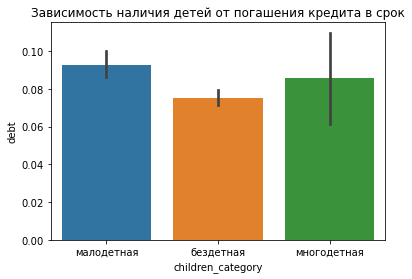

In [44]:
seaborn.barplot(x='children_category', y='debt', data=data).set_title('Зависимость наличия детей от погашения кредита в срок');

In [45]:
data.groupby('children_category')['debt'].mean()

children_category
бездетная      0.075353
малодетная     0.092501
многодетная    0.085526
Name: debt, dtype: float64

Как видим, семьи без детей чаще отдают кредиты в срок, так как суммарные расходы семей, где дети есть, больше, чем у бездетных семей.

### 5.2 Есть ли зависимость между семейным положением и возвратом кредита в срок? <a id="5.2id"></a>

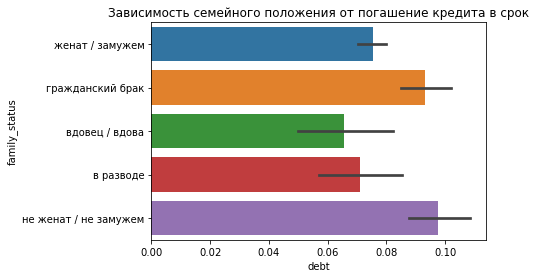

In [46]:
seaborn.barplot(x='debt', y='family_status', data=data).set_title('Зависимость семейного положения от погашение кредита в срок');

In [47]:
data.groupby('family_status')['debt'].mean()

family_status
в разводе                0.071130
вдовец / вдова           0.065693
гражданский брак         0.093202
женат / замужем          0.075421
не женат / не замужем    0.097509
Name: debt, dtype: float64

Клиенты, не состоящие в официальном браке чаще отдают кредиты вовремя. Это может быть связано с тем, что у таких пар  чаще бывает раздельный бюджет. Люди рассчитывают больше на себя и ограничены собственным доходом, не охотно берут долгосрочне кредиты, которые сложно возвращать.

### 5.3 Есть ли зависимость между уровнем дохода и возвратом кредита в срок? <a id="5.3id"></a>

Покажем численно и визуально зависимость уровня дохода от своевременного погашения кредита

In [48]:
data.groupby('total_income_category')['debt'].mean()

total_income_category
высокий доход    0.071349
низкий доход     0.079545
средний доход    0.086726
Name: debt, dtype: float64

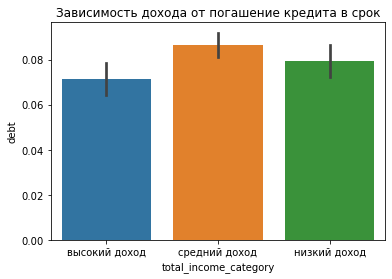

In [49]:
seaborn.barplot(x='total_income_category', y='debt', data=data).set_title('Зависимость дохода от погашение кредита в срок');

По группировке и графику видно, что клиенты со средним и высоким доходами более склонны выплачивать кредит в срок (почти на 20% чаще, чем с низким). Вероятно, получаемый ими доход позволяет откладывать больше средств для погашения кредита, в то время как клиенты с низким доходом вынуждены большую часть средств тратить на товары и услуги первой необходимости.
Попробуем с помощью сводной таблицы увидеть еще одну зависимость между образованием и своевременной выплатой кредита.

In [50]:
data_pivot_by_education = data.pivot_table(index=['total_income_category'], columns='education', values='debt', aggfunc='mean')
data_pivot_by_education

education,высшее,начальное,неоконченное высшее,среднее,ученая степень
total_income_category,,,,,
высокий доход,0.046629,0.095238,0.123932,0.082798,0.0
низкий доход,0.057292,0.063636,0.076389,0.084005,0.0
средний доход,0.056574,0.153846,0.076503,0.095898,0.0


Как видим, образование также косвенно влияет на погашение кредита в срок. Чем оно выше, тем в среднем выше доход у заемщиков, тем они быстрее погашают задолжность перед банком. Таким образом, банкам также стоит учитывать уровень образования у своих клиентов.

### 5.4 Как разные цели кредита влияют на его возврат в срок? <a id="5.4id"></a>

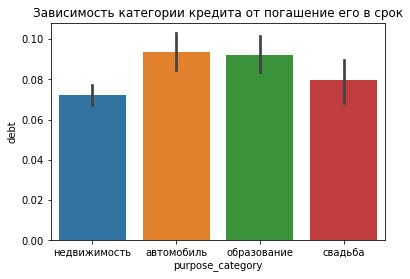

In [51]:
seaborn.barplot(x='purpose_category', y='debt', data=data).set_title('Зависимость категории кредита от погашение его в срок');

In [52]:
data.groupby('purpose_category')['debt'].mean()

purpose_category
автомобиль      0.093547
недвижимость    0.072314
образование     0.092177
свадьба         0.079657
Name: debt, dtype: float64

Чаще всего в срок заемщики погашают кредиты за покупку автомобиля и оплату образования. Это связано с более низкой процентной ставкой на данные категории, а также сроком их выплаты, в отличие от недвижимости. 

### Шаг 6. Итоги исследования:  <a id="6id"></a>

На основе данных о клиентах банка нам удалось провести анализ кредитоспособности заемщиков. Главной задачей было выяснить, как влияют такие показатели, как семейное положение и количество детей на погашение кредита в срок. 

Выяснили, что клиенты без детей чаще отдают долг банку вовремя. Это связано с тем, что, как правило, сумарные расходы семей с детьми больше, чем у бездетных - свободных денежных средств для оплаты кредита становится меньше.
 
Анализ показал, что люди не состоящие в официальном браке, а также холостые чаще выплачивают кредит в срок. Скорее всего это связано с большей финансовой автономностью, раздельными бюджетами и невысоким желанием рисковать, когда ответственность за свое благополучие лежит только на самом человеке. Отсутствие семьи так же снижает риск появления больших и непредвиденных расходов.

Были проверены связи между своевременной выплатой кредита, уровнем дохода, а так же причиной взятия кредита.
Чем выше уровень дохода, тем чаще заемщики отдают долг в срок. Цели кредита тоже влияют на срок погащения кредита. Кредиты за покупку автомобиля и образование отдаются чаще вовремя, чем кредиты на недвижимость и свадьбу. Способность выплачивать кредит за недвижимость может меняться, так как больше растянута во времени, чем кредиты по остальным категориям.